In [1]:
import numpy as ny
import tensorflow as tw
# from tensorflow import keras as k
# from tensorflow.keras import layers

In [2]:
class sp(tw.keras.layers.Layer):
    def call(self, ip):
        mz, vlz = ip
        b = tw.shape(mz)[0]
        d = tw.shape(mz)[1]
        ep = tw.keras.backend.random_normal(shape=(b, d))
        return mz + tw.exp(0.5 * vlz) * ep

In [3]:
ldim = 2

ipenc = tw.keras.Input(shape=(28, 28, 1))
md = tw.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(ipenc)
md = tw.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(md)
md = tw.keras.layers.Flatten()(md)
md = tw.keras.layers.Dense(16, activation="relu")(md)
mz = tw.keras.layers.Dense(ldim, name="mz")(md)
vlz = tw.keras.layers.Dense(ldim, name="vlz")(md)
zi = sp()([mz, vlz])
enc = tw.keras.Model(ipenc, [mz, vlz, zi], name="enc")
enc.summary()

Model: "enc"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
________________________________________________________________________________________________

In [4]:
ipl = tw.keras.Input(shape=(ldim,))
md = tw.keras.layers.Dense(7 * 7 * 64, activation="relu")(ipl)
md = tw.keras.layers.Reshape((7, 7, 64))(md)
md = tw.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(md)
md = tw.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(md)
odec = tw.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(md)
dec = tw.keras.Model(ipl, odec, name="decoder")
dec.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [17]:
class VAE(tw.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tw.GradientTape() as tape:
            z_mean, z_log_var, z = enc(data)
            reconstruction = dec(z)
            reconstruction_loss = tw.reduce_mean(
                tw.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tw.square(z_mean) - tw.exp(z_log_var)
            kl_loss = tw.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [18]:
(x_train, _), (x_test, _) = tw.keras.datasets.mnist.load_data()
mnist_digits = ny.concatenate([x_train, x_test], axis=0)
mnist_digits = ny.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(enc, dec)
vae.compile(optimizer=tw.keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=1, batch_size=4096)

 3/18 [====>.........................] - ETA: 35s - loss: 541.2767 - reconstruction_loss: 541.2708 - kl_loss: 0.0059

KeyboardInterrupt: 

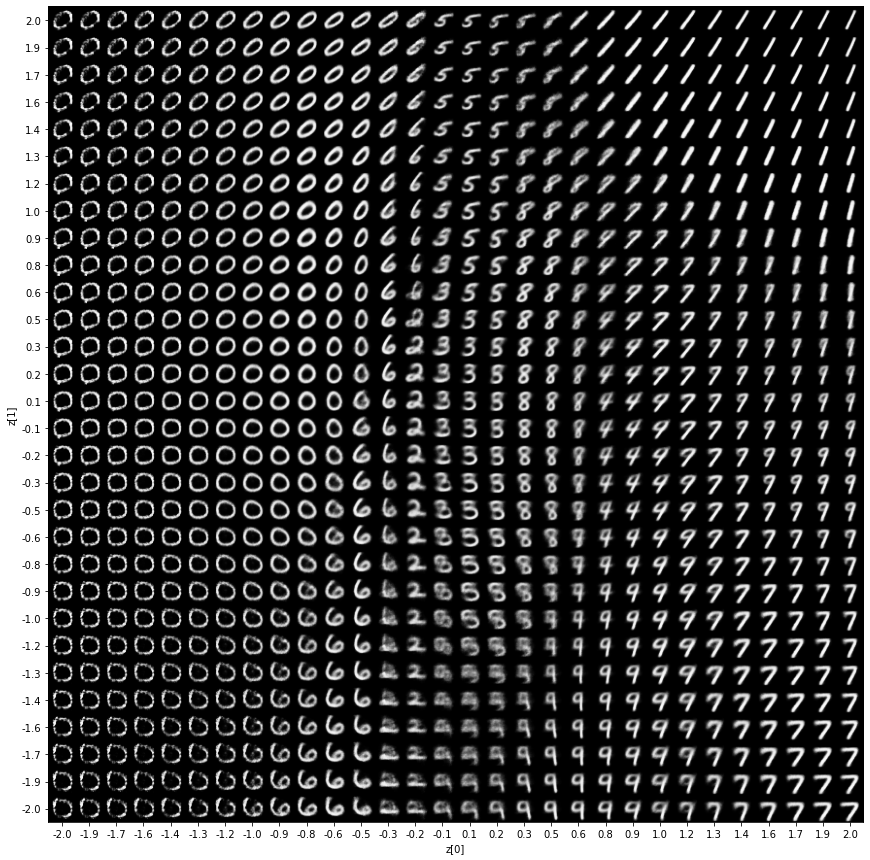

In [15]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)